# An experimentation of computer vision challenge for beginer(75% val_accuracy in 25 epochs, and 79% after 50 epochs without data augmentation). 

The codes of this notebook are taken on keras documentation. I am just crying to give some explaination for that code.
I hope that this migth be helpful for you.

### Table of interest:
1. Introduction
2. Import and Preprocess the data
 + 2.1 Import all required libraries
 + 2.2 Import and preproces of data
 + 2.3 Distribution of data.
3. Defining the model architecture Using ConVnets
4. Model training
5. Evaluate the model
 + 5.1 Training and validations cuvre
 + 5.2 Score trained model and prediction.
 + 5.3 Confusion matrix.
 + 5.4 Classification report.
 + 5.5 Check for the predictions.
6. Save model and weights

## 1. Introduction.
The CIFAR-10 dataset contains 60,000 color images of 32 x 32 pixels in 3 channels divided into 10
classes. Each class contains 6,000 images. The training set contains 50,000 images, while the test sets
provides 10,000 images. This image taken from the CIFAR repository ( <a href = "https://www.cs.toronto.edu/~kriz/cifar.html">https://www.cs.toronto.edu/~kriz/cifar.html </a>). This is a classification problem with 10 classes(muti-label classification). We can take a view on this image for more comprehension of the dataset. 

![cifar10.png](https://github.com/borislevant/SciComPy/blob/master/cifar10.png?raw=1)


The challenge is to recognize previously unseen images and assign them to one of the 10 classes.

Ok Let's get started.

## 2. Import and Preprocess the data

### 2.1 Import all required libraries

In [ ]:
from __future__ import print_function
from tensorflow import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline


Let's setting the models hyperparameters and others global parameters.

In [ ]:
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 100
data_augmentation = False

### 2.2 Import and preproces of data 
We load the data and split it between train and test sets


In [ ]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


### 2.3 Distribution of data.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


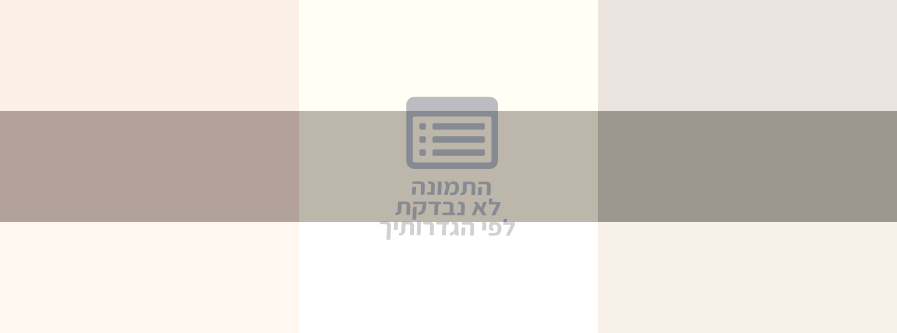

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

As we can see, each classe contain exacly 6000 examples( 5000 for training and 1000 for test).

The graph above is very important for the training, for example if we had just 1000 samples of label 1 that will be a problem , the model will find difficulties to detect label 1"less accuracy ", so that's not going to happend everything look fine. It's important to know the distribution of dataset behind different classes because the goodness of our model depend on it.

Now let's doing some preprocessing.

The output variable have 10 posible values. This is a multiclass classification problem. We need to encode these lables to one hot vectors (ex : "bird" -> [0,0,1,0,0,0,0,0,0,0]). 

In [ ]:
# Normalize the data. Before we need to connvert data type to float for computation.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## 3. Defining the model architecture Using ConVnets

Now Let us define a suitable deep net.

* In the first stage, Our net will learn **32 convolutional filters**, each of which with a **3 x 3 size**. The output dimension is the same one of the input shape, so it will be **32 x 32** and activation is `relu`, which is a simple way of introducing non-linearity; folowed by another **32 convolutional filters**, each of which with a **3 x 3 size** and activation is also `relu`. After that we have a **max-pooling** operation with `pool size` **2 x 2** and a `dropout` at **25%.**
* In the next stage in the deep pipeline, Our net will learn **64 convolutional filters**, each of which with a **3 x 3 size**. The output dimension is the same one of the input shape and activation is `relu`; folowed by another **64 convolutional filters**, each of which with a **3 x 3 size** and activation is also `relu`. After that we have a **max-pooling** operation with `pool size` **2 x 2** and a `dropout` at **25%.**
* And the Final stage in the deep pipeline is a dense network with **512 units** and `relu` activation followed by a `dropout` at **50%** and by a `softmax` layer with **10 classes as output**, one for each category.

Now let us look at the code review for our architecture.

In [ ]:
#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_12 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_13 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 32)        0         
                                                      

And now, let us train the model.

## 4. Model training

Before making network ready for training we have to make sure to add below things:
*   **A loss function:** to measure how good the network is
*   **An optimizer:** to update network as it sees more data and reduce loss value
*   **Metrics:** to monitor performance of network

**Also note that for data augmentation:**
* One of the most commun tehnique to avoid overfitting is data augmentation. And We know that overfitting is generaly occur when we don't have enought data for training the model. To avoid this overfitting problem, we need to expand artificially our dataset. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit. 

* Different data aumentation techniques are as follows: Cropping, Rotating, Scaling, Translating, Flipping, Adding Gaussian noise to input images, etc...


In [ ]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
y_test.shape

(10000, 10)

In [ ]:
history = None  # For recording the history of trainning process.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4)

Not using data augmentation.
Epoch 1/100
1563/1563 [==============================] - 252s 160ms/step - loss: 1.8008 - accuracy: 0.3403 - val_loss: 1.5102 - val_accuracy: 0.4599
Epoch 2/100
1563/1563 [==============================] - 252s 161ms/step - loss: 1.4773 - accuracy: 0.4634 - val_loss: 1.4399 - val_accuracy: 0.4896
Epoch 3/100
1563/1563 [==============================] - 249s 159ms/step - loss: 1.3373 - accuracy: 0.5243 - val_loss: 1.2209 - val_accuracy: 0.5687
Epoch 4/100
1563/1563 [==============================] - 256s 164ms/step - loss: 1.2404 - accuracy: 0.5587 - val_loss: 1.1637 - val_accuracy: 0.5955
Epoch 5/100
1563/1563 [==============================] - 248s 159ms/step - loss: 1.1626 - accuracy: 0.5898 - val_loss: 1.1112 - val_accuracy: 0.6114
Epoch 6/100
1563/1563 [==============================] - 249s 159ms/step - loss: 1.0975 - accuracy: 0.6152 - val_loss: 1.0151 - val_accuracy: 0.6454
Epoch 7/100
1563/1563 [==============================] - 248s 158ms/step - lo

## 5. Evaluate the model.

### 5.1 Training and validation curves.
Let's see the training and validation process by the visualization of history of fitting. This allow us to quickly know if how our model fit our data **(overfitting, underfitting, model convergence, etc...)**

In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)


As we can see, after 60 epochs, the accuracy of our model doesn't really increase. But our model doesn't overffit.
### 5.2 Score trained model and prediction.

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

Now Let's investigate for errors.
### 5.3 Confusion matrix.
Confusion matrix can be very helpfull to see your model drawbacks.
We plot the confusion matrix of the validation results.
For good vizualization of our confusion matrix, we have to define to fonction.

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

### 5.4 Classification report

This will allow us to evaluate the model with other metrics **(Precision, Recall, F1 score, etc...)**

In [ ]:
print(classification_report(Y_true, Y_pred_classes))

### 5.5 Check the predictions.

In [ ]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)


#### - Check the wrong predictions.

In [ ]:
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)


#### - Check the most important errors.

In [ ]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(12,6))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((32,32,3)))
            ax[row,col].set_title("Predicted:{}\nTrue:{}".
                                  format(labels[pred_errors[error]],labels[obs_errors[error]]))
            n += 1
            ax[row,col].axis('off')
            plt.subplots_adjust(wspace=1)

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 10 errors 
most_important_errors = sorted_dela_errors[-10:]

# Show the top 10 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)

#### - Testing the model with the test images in the test set.
Now we can play with our model for some fun.

In [ ]:
def show_test(number):
    fig = plt.figure(figsize = (3,3))
    test_image = np.expand_dims(x_test[number], axis=0)
    test_result = model.predict_classes(test_image)
    plt.imshow(x_test[number])
    dict_key = test_result[0]
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],
                                                      labels[Y_true[number]]))

In [ ]:
show_test(20)

## 6. Save model and weights

Note that we need to firstly indicate the directory to save the model and the name of our model. 

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])




### Hope that you found this notebook helpful for you. More to come.

### Thanks for sharing it and for your suggestions.
